In [1]:
from datasets import load_dataset
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
dataset_path = "results/clinvar/mis_pat_ben"
plot_dir = "../../results/plots/"

In [9]:
models = [
    "CADD.RawScore",
    "phyloP",
    "phastCons",
    "phyloP-Zoonomia",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    "ESM-1b",
]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
}

V = load_dataset(f"../../{dataset_path}", split="test").to_pandas()
d = Path(f"../../results/preds/{dataset_path}")

for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,label,id,review_status,consequence,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,phyloP-241-mammals,GPN-MSA,ESM-1b
0,1,930165,G,A,Benign,1164676,"criteria_provided,_single_submitter",missense_variant,-4.225333,-5.113,-1.000,-8.617,-5.230469,-8.967
1,1,930204,G,A,Benign,1170208,"criteria_provided,_single_submitter",missense_variant,-2.879554,-3.430,-1.000,-1.046,-2.882812,-5.529
2,1,930285,G,A,Benign,1165489,"criteria_provided,_single_submitter",missense_variant,-0.091394,-0.322,-0.107,0.194,-1.540039,-4.687
3,1,930314,C,T,Benign,1170010,"criteria_provided,_single_submitter",missense_variant,-2.481464,-3.747,-0.081,-3.625,-4.984375,-4.295
4,1,935779,G,A,Benign,1167937,"criteria_provided,_single_submitter",missense_variant,-1.831757,-2.981,-1.000,0.251,4.371094,-2.864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50159,Y,2787412,C,T,Pathogenic,9747,no_assertion_criteria_provided,missense_variant,-2.351070,-5.679,-1.000,-6.769,-4.914062,-11.344
50160,Y,2787426,C,G,Pathogenic,9739,"criteria_provided,_single_submitter",missense_variant,-2.215825,-5.679,-1.000,-5.114,-6.519531,-9.000
50161,Y,2787515,C,A,Pathogenic,492908,no_assertion_criteria_provided,missense_variant,-1.614399,0.091,-0.000,-0.120,-0.703125,-4.780
50162,Y,2787551,C,T,Pathogenic,9754,no_assertion_criteria_provided,missense_variant,-0.541464,-0.675,-0.989,-0.120,-0.416016,-4.299


In [10]:
V.dropna(subset=models, inplace=True)
V.shape

(48268, 14)

In [12]:
rows = []
for m in models:
    y_true = V.label == "Pathogenic"
    y_score = -V[m]
    AUROC = roc_auc_score(y_true, y_score)
    AUPRC = average_precision_score(y_true, y_score)
    rows.append([m, AUROC, AUPRC])
results = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC"]).sort_values("AUROC", ascending=False)
results

,Model,AUROC,AUPRC
5,ESM-1b,0.914224,0.904751
0,CADD,0.913639,0.877106
4,GPN-MSA,0.906944,0.876353
1,phyloP-100-vertebrates,0.855577,0.808643
3,phyloP-241-mammals,0.803965,0.704849
2,phastCons-100-vertebrates,0.774796,0.646856


In [13]:
n_pos, n_neg = V.label.value_counts()[["Pathogenic", "Benign"]]
n_pos, n_neg

(21275, 26993)

In [15]:
palette = {
    "GPN-MSA": "C0",
    "CADD": "C1",
    "phyloP": "C2",
    "ESM-1b": "C3",
    "NT": "C4",
    "SpliceAI": "C5",
    "Enformer": "C6",
    "HyenaDNA": "C9",
    
    "phyloP-100-vertebrates": "C2",
    "phyloP-241-mammals": "C7",
    "phastCons-100-vertebrates": "C8",
    
    "NT-500m-human-ref": "gray",
    "NT-500m-1000g": "gray",
    "NT-2.5b-1000g": "gray",
    "NT-2.5b-multi-species": "C4",
    
    r"Enformer ($L^1$)": "C7",
    r"Enformer ($L^2$)": "C6",
    r"Enformer ($L^\infty$)": "C8",
}

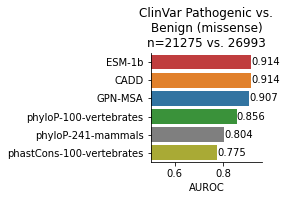

In [30]:
plt.figure(figsize=(2,2))
g = sns.barplot(
    data=results,
    y="Model",
    x="AUROC",
    palette=palette,
);
g.set(xlim=0.5)
plt.ylabel("")
plt.title(f"ClinVar Pathogenic vs.\nBenign (missense)\nn={n_pos} vs. {n_neg}")
for bar in g.patches:
    g.text(
        bar.get_width(),  # X position, here at the end of the bar
        bar.get_y() + bar.get_height()/2,  # Y position, in the middle of the bar
        f'{bar.get_width():.3f}',  # Text to be displayed, formatted to 3 decimal places
        va='center'  # Vertical alignment
    )
sns.despine();
#plt.savefig(plot_dir + "clinvar_mis_pat_ben.pdf", bbox_inches="tight")